In [1]:
import os 
import gc 
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_AUTO_GC'] = '1'
#sys.path.insert(0,'./CTC-OptimizedLoss')
sys.path.insert(0, './rnnt/source')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from itertools import cycle, chain
from random import shuffle
from jiwer import wer

from rnnt_loss import rnnt_loss 

# from tf_seq2seq_losses import classic_ctc_loss 
# from ctc_focal_loss import CTCFocalLoss
# from mwer_loss import CTCMWERLoss

import json

from IPython.display import Image
from tensorflow.keras.utils import plot_model

In [2]:
print("Tensorflow", tf.__version__)

Tensorflow 2.13.0


In [3]:
data_path = '/home/ran/AI/asl_spell/data'
train_tfr_path = data_path + '/train_tfr'
supplemental_tfr_path = data_path + '/supplemental_tfr'

In [4]:
model_path = '/home/ran/AI/asl_spell/saved_models/ctc_asl_v2/asl_ctc_v2.tflite'

In [5]:
lh_cols = [f'{i}_left_hand_{j}' for i in ('x', 'y') for j in range(21)]
rh_cols = [f'{i}_right_hand_{j}' for i in ('x', 'y') for j in range(21)]
pose_cols = [f'{i}_pose_{j}' for i in ('x', 'y') for j in range(33)]

selected_cols = lh_cols + rh_cols + pose_cols

In [6]:
# selected_cols

In [7]:
c = tf.convert_to_tensor(selected_cols[:42])
c = tf.reshape(c, [2, 21])
c = tf.transpose(c)

c

<tf.Tensor: shape=(21, 2), dtype=string, numpy=
array([[b'x_left_hand_0', b'y_left_hand_0'],
       [b'x_left_hand_1', b'y_left_hand_1'],
       [b'x_left_hand_2', b'y_left_hand_2'],
       [b'x_left_hand_3', b'y_left_hand_3'],
       [b'x_left_hand_4', b'y_left_hand_4'],
       [b'x_left_hand_5', b'y_left_hand_5'],
       [b'x_left_hand_6', b'y_left_hand_6'],
       [b'x_left_hand_7', b'y_left_hand_7'],
       [b'x_left_hand_8', b'y_left_hand_8'],
       [b'x_left_hand_9', b'y_left_hand_9'],
       [b'x_left_hand_10', b'y_left_hand_10'],
       [b'x_left_hand_11', b'y_left_hand_11'],
       [b'x_left_hand_12', b'y_left_hand_12'],
       [b'x_left_hand_13', b'y_left_hand_13'],
       [b'x_left_hand_14', b'y_left_hand_14'],
       [b'x_left_hand_15', b'y_left_hand_15'],
       [b'x_left_hand_16', b'y_left_hand_16'],
       [b'x_left_hand_17', b'y_left_hand_17'],
       [b'x_left_hand_18', b'y_left_hand_18'],
       [b'x_left_hand_19', b'y_left_hand_19'],
       [b'x_left_hand_20', b'y_l

In [8]:
val_frac = 20

trainfiles = os.listdir(train_tfr_path)
trainfiles = [f'{train_tfr_path}/{e}' for e in trainfiles]
n_train = len(trainfiles)
trainfiles = trainfiles[(n_train // val_frac):]
valfiles = trainfiles[:(n_train // val_frac)]

supp_files = os.listdir(supplemental_tfr_path)
supp_files = [f'{supplemental_tfr_path}/{e}' for e in supp_files]
n_supp = len(supp_files)
supp_train_files = supp_files[(val_frac // 10):]
supp_valid_files = supp_files[:(val_frac // 10)]

mixed_train_files = list(chain(*zip(cycle(trainfiles), supp_train_files)))
mixed_val_files = list(chain(*zip(cycle(valfiles), supp_valid_files)))

In [9]:
# mixed_train_files

In [10]:
def parse_fn(serialized):
    # Define the features we want to extract
    
    # Parse the serialized record using the feature dictionary
    parsed = tf.io.parse_sequence_example(serialized, 
                                          context_features={'phrase': tf.io.VarLenFeature(tf.int64)},
                                          sequence_features={col: tf.io.VarLenFeature(tf.float32) for col in selected_cols})
    
    sequence = ([tf.sparse.to_dense(parsed[1][f]) for f in selected_cols])
    sequence = tf.transpose(tf.squeeze(sequence))
    
    phrase = tf.sparse.to_dense(parsed[0]['phrase'])
    phrase = tf.cast(phrase, tf.int32)
    
    return sequence, phrase

In [11]:
batch_size = 32
# padding_values=(-1.0, 100)
padding_values = (59.0, 59)
padded_shapes=([None, 150], [None])

def create_dataset(files):
    ds = tf.data.TFRecordDataset(files)
    ds = (
        ds
        .map(parse_fn, num_parallel_calls=(tf.data.AUTOTUNE))
        .shuffle(batch_size * 100)
        .padded_batch(batch_size, padding_values=padding_values, padded_shapes=padded_shapes)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    return ds

In [12]:
# print(selected_cols[:])

In [13]:
len(selected_cols)

150

In [14]:
with open(data_path + "/character_to_prediction_index.json", 'r') as f:
    character_map = json.load(f)
    character_map["<pad>"] = 59
rev_character_map = {j:i for i,j in character_map.items()}

In [15]:
# row = tf.constant([1, 2, 3, 3], dtype = "int64")
# row = row[row < 3]
# len = tf.expand_dims(tf.shape(row)[0], 0)
# len

# batch = tf.constant(np.arange(15))
# batch = tf.reshape(batch, [3, 5])
# batch = tf.math.less(batch, tf.constant([11], dtype="int64"))
# batch = tf.cast(batch, dtype="int64")
# batch = tf.math.reduce_sum(batch, axis=1)
# batch = tf.expand_dims(batch, 1)
# batch


In [16]:
# from tensorflow.python.ops import math_ops
# from tensorflow.python.ops import array_ops
from tensorflow.python.util import dispatch
# from tensorflow.python.ops import ctc_ops as ctc
from tensorflow.python.keras import backend_config

epsilon = backend_config.epsilon

@dispatch.add_dispatch_support
def my_ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    # sparse_labels = tf.cast(
    #     keras.backend.ctc_label_dense_to_sparse(y_true, label_length), tf.int32
    # )

    # y_pred = tf.math.log(
    #     tf.compat.v1.transpose(y_pred, perm=[1, 0, 2]) + epsilon()
    # )

    # y_pred = tf.math.log(y_pred + epsilon())

    # loss = classic_ctc_loss(
    #     labels=y_true,
    #     logits=y_pred,
    #     label_length=label_length,
    #     logit_length=input_length,
    #     blank_index=59
    # )

    # loss = tf.nn.ctc_loss(
    #     labels=sparse_labels,
    #     logits=y_pred,
    #     label_length=label_length,
    #     logit_length=input_length,
    #     blank_index=59,
    #     logits_time_major = False
    # )
    
    loss = rnnt_loss(logits=y_pred, 
                     labels=y_true, 
                     label_length=label_length, 
                     logit_length=input_length)
    
    # loss = mwer_loss(
    #     logit=y_pred,
    #     labels=y_true,
    #     logit_length=input_length,
    #     label_length=label_length
    # )

    # return tf.expand_dims(loss, 1)
    # print(loss)
    return loss

    # return tf.expand_dims(
    #     tf.compat.v1.nn.ctc_loss(
    #         inputs=y_pred, labels=sparse_labels, 
    #         time_major=False,
    #         sequence_length=input_length
    #     ),
    #     1,
    # )

In [17]:
def find_lengths(batch):
    batch = tf.cast(batch, dtype="int64")
    batch = tf.math.less(batch, tf.constant([59], dtype="int64"))
    batch = tf.cast(batch, dtype="int64")
    batch = tf.math.reduce_sum(batch, axis=1)
    batch = tf.expand_dims(batch, 1)
    return batch

In [18]:
def CTCLoss_hard(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # input_length = find_lengths(y_pred)
    # label_length = find_lengths(y_true)
    
    # print(input_length)
    # print(label_length)

    # loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_lengths, label_lengths)
    loss = my_ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [19]:
def CTCLoss_easy(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # print(input_length)
    # print(label_length)

    # loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_lengths, label_lengths)
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [20]:
def CTCDecoder():
    def decoder(y_pred):
        
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.cast(input_shape[1], tf.int64)

        x = y_pred
        x = tf.squeeze(tf.math.argmax(x, axis=2))
        x = tf.cast(x, tf.int64)
        
        j0 = tf.constant(0, dtype=tf.int64)

        inp0 = tf.cast(x, tf.int64)
        pc0 = tf.constant(1000, dtype=tf.int64)
        
        out0 = tf.ones(shape=[1], dtype=tf.int64) * tf.constant(59, shape=[1], dtype=tf.int64)
        
        j_pc_inp_out_init = [j0, pc0, inp0, out0] 
        
        cond = lambda j, pc, inp, out: j < input_length
        
        body = lambda j, pc, inp, out: tf.cond(tf.equal(inp[j],pc), 
                                               lambda: (j + 1, inp[j], inp, out), 
                                               lambda: (j + 1, inp[j], inp, tf.concat([out, tf.expand_dims(inp[j], 0)], 0)))

        x = tf.while_loop(cond, body, j_pc_inp_out_init, 
                          shape_invariants=[j0.get_shape(), tf.TensorShape(None), 
                                            inp0.get_shape(), tf.TensorShape([None])])[3]

        x = x[x<59]

        x = tf.one_hot(x, 59)
        
        return x

        
        # input_shape = tf.keras.backend.shape(y_pred)
        # input_length = tf.ones(shape=input_shape[0]) * tf.keras.backend.cast(
        #     input_shape[1], 'float32')
        # decoded = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=False)[0][0]

        # decoded = decoded[decoded > -1]
        # # decoded = tf.squeeze(decoded)
        # decoded = tf.one_hot(decoded, 59)
        
        # return decoded

    return tf.keras.layers.Lambda(decoder, name='outputs')

In [21]:
def PreProcessor():
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(selected_cols)],
                                                dtype=tf.float32, name='inputs')])
    def preprocessor(x):
        
        x = tf.cast(x, tf.float32)

        x = x[None]
        
        x = tf.cond(tf.shape(x)[1] < 2, 
            lambda: tf.zeros((1, 2, len(selected_cols))), 
            lambda: tf.identity(x))

        x = x[0]
        
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

        x = x[None]
        
        return x
    
    return tf.keras.layers.Lambda(preprocessor, name='preprocessor')

In [22]:
def Schedule_Wrap(lr_schedule, min_rate):
    # lr_schedule = lr_schedule
    
    def schedule_wrap(step=0):
        min_lr = tf.Variable(min_rate, trainable=False)
        exp_lr = lr_schedule(step)
        out = tf.maximum(min_lr, exp_lr)
        return out

    return schedule_wrap

In [23]:
class Slicer(layers.Layer):
    # @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, len(selected_cols)],
    #                                             dtype=tf.float32)])
    def __init__(self):
        super().__init__(name = "slicer")
        self.hand_shaper = layers.Reshape((-1, 2, 21))
        self.pose_shaper = layers.Reshape((-1, 2, 33))

    def call(self, x):
        lh, rh, pose = tf.split(x, [42, 42, 66], axis=-1)

        # hand_shaper = layers.Reshape((-1, 2, 21))
        lh = self.hand_shaper(lh)
        lh = tf.transpose(lh, [0, 1, 3, 2])

        rh = self.hand_shaper(rh)
        rh = tf.transpose(rh, [0, 1, 3, 2])

        pose = self.pose_shaper(pose)
        pose = tf.transpose(pose, [0, 1, 3, 2])
        
        return (lh, rh, pose)



# def Slicer():
#     # @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, len(selected_cols)],
#     #                                             dtype=tf.float32, name="slicer")])
#     def slicer(x):
#         lh, rh, pose = tf.split(x, [42, 42, 66], axis=-1)
        
#         return (lh, rh, pose)

#     return tf.keras.layers.Lambda(slicer, name="slicer")




In [24]:
class Slicer2(layers.Layer):
    def __init__(self, n_slices):
        super().__init__(name = "slicer2")
        self.n_slices = n_slices
        self.input_dim = None

    
    def call(self, x):
        if self.input_dim == None:
            self.initialize(x)

        out = []
        for gp in self.groups:
            out.append(tf.gather(x, self.groups[gp], axis=2))

        return out


    def initialize(self, x):
        
        def split(a, n):
            k, m = divmod(len(a), n)
            return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
        
        self.input_dim = x.shape[2]
        
        all_idx = list(range(self.input_dim))
        shuffle(all_idx)

        slices = list(split(all_idx, self.n_slices))

        self.groups = {f"group_{i}": slices[i] for i in range(self.n_slices)}
        

        

In [25]:
class MyConv1D(layers.Layer):
    def __init__(self, n_units=32, name=None):
        super().__init__(name = name)
        # self.units = [layers.Dense(1, activation='elu', 
        #                            kernel_initializer = tf.keras.initializers.LecunNormal()) for _ in range(n_units)]
        
        self.units = [layers.Dense(1, activation='relu') for _ in range(n_units)]
        self.cat = layers.Concatenate()
    
    def call(self, x):
        outputs = [u(x) for u in self.units]
        x = self.cat(outputs)

        return x


In [26]:
class MyConv1DWide(layers.Layer):
    def __init__(self, input_shape, n_units=32, width=14, name= None):
        super().__init__(name = name)

        self.in_shaper = layers.Reshape((-1, input_shape, 1))
        
        self.conv = layers.Conv2D(
            n_units, [width, input_shape], activation='relu',
            input_shape = (None, input_shape, 1),
            padding = "same"
        )

        self.out_shaper = None
        

    def call(self, x):
        x = self.in_shaper(x)
    
        x = self.conv(x)

        if self.out_shaper is None:
            self.out_shaper = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))

        x = self.out_shaper(x)

        return x

In [27]:
class SpatialConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, 
                 input_shape, name= None):
        
        super().__init__(name = name)

        pad_width = kernel_size[0]
        pad_height = kernel_size[1]

        self.padding = layers.ZeroPadding2D(padding=(pad_width, pad_height), 
                                            data_format='channels_last')

        self.conv = layers.Conv2D(filters = filters,
                                  kernel_size = kernel_size,
                                  input_shape = input_shape,
                                  kernel_initializer= tf.keras.initializers.HeUniform(seed=42),
                                  bias_initializer=tf.keras.initializers.HeUniform(seed=42),
                                  strides=1,
                                  padding = "same",
                                  activation = "relu")

        self.maxpool = layers.MaxPooling2D(pool_size = (1, kernel_size[1]), 
                                            data_format = 'channels_last', strides=1)

        self.filters = filters

        self.out_shaper = layers.Reshape((-1, self.filters))

    
    def call(self, x):
        # x = self.padding(x)
        
        x = self.conv(x)

        x = self.maxpool(x)

        x = self.out_shaper(x)

        return x


In [35]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""

    input_train = layers.Input((None, input_dim), name="inputs_train")
    input_prod = layers.Input((input_dim), name="inputs")
    
    preprocessor = PreProcessor()
    x = input_train
    x_p = preprocessor(input_prod)
    
    slicer = Slicer()
    x_l, x_r, x_o = slicer(x)
    x_lp, x_rp, x_op = slicer(x_p)


    # conv_l = MyConv1D(128)
    # x_l_c1 = conv_l(x_l)
    # x_lp_c1 = conv_l(x_lp)

    # conv_r = MyConv1D(128)
    # x_r_c1 = conv_r(x_r)
    # x_rp_c1 = conv_r(x_rp)

    # conv_o = MyConv1D(64)
    # x_o_c1 = conv_o(x_o)
    # x_op_c1 = conv_o(x_op)

    # conv_l2 = MyConv1DWide(42, 32)
    # x_l_c2 = conv_l2(x_l)
    # x_lp_c2 = conv_l2(x_lp)

    # conv_r2 = MyConv1DWide(42, 32)
    # x_r_c2 = conv_r2(x_r)
    # x_rp_c2 = conv_r2(x_rp)

    # conv_o2 = MyConv1DWide(66, 16)
    # x_o_c2 = conv_o2(x_o)
    # x_op_c2 = conv_o2(x_op)

    # Width 1 convolutions

    conv_l_1 = SpatialConv2D(filters=256, 
                           kernel_size=[1, 21],
                           input_shape=(None, None, 21, 2),
                           name = "left_hand_conv_1")
    x_l_c1 = conv_l_1(x_l)
    x_lp_c1 = conv_l_1(x_lp)

    conv_r_1 = SpatialConv2D(filters=256, 
                           kernel_size=[1, 21],
                           input_shape=(None, None, 21, 2),
                           name= "right_hand_conv_1")
    x_r_c1 = conv_r_1(x_r)
    x_rp_c1 = conv_r_1(x_rp)

    conv_p_1 = SpatialConv2D(filters=128, 
                           kernel_size=[1, 33],
                           input_shape=(None, None, 33, 2),
                           name = "pose_conv_1")
    x_o_c1 = conv_p_1(x_o)
    x_op_c1 = conv_p_1(x_op)

    # Wide convolutions

    conv_l_2 = SpatialConv2D(filters=64, 
                           kernel_size=[7, 21],
                           input_shape=(None, None, 21, 2),
                           name = "left_hand_conv_2")
    x_l_c2 = conv_l_2(x_l)
    x_lp_c2 = conv_l_2(x_lp)
    
    conv_r_2 = SpatialConv2D(filters=64, 
                           kernel_size=[7, 21],
                           input_shape=(None, None, 21, 2),
                           name= "right_hand_conv_2")
    x_r_c2 = conv_r_2(x_r)
    x_rp_c2 = conv_r_2(x_rp)

    conv_p_2 = SpatialConv2D(filters=32, 
                           kernel_size=[7, 33],
                           input_shape=(None, None, 33, 2),
                           name = "pose_conv_2")
    x_o_c2 = conv_p_2(x_o)
    x_op_c2 = conv_p_2(x_op)

    
    # Even Wider convolutions

    conv_l_3 = SpatialConv2D(filters=32, 
                           kernel_size=[21, 21],
                           input_shape=(None, None, 21, 2),
                           name = "left_hand_conv_3")
    x_l_c3 = conv_l_3(x_l)
    x_lp_c3 = conv_l_3(x_lp)
    
    conv_r_3 = SpatialConv2D(filters=32, 
                           kernel_size=[21, 21],
                           input_shape=(None, None, 21, 2),
                           name= "right_hand_conv_3")
    x_r_c3 = conv_r_3(x_r)
    x_rp_c3 = conv_r_3(x_rp)

    conv_p_3 = SpatialConv2D(filters=16, 
                           kernel_size=[21, 33],
                           input_shape=(None, None, 33, 2),
                           name = "pose_conv_3")
    x_o_c3 = conv_p_3(x_o)
    x_op_c3 = conv_p_3(x_op)


    # Concatenate convolutional outputs
    
    lh_cat = layers.Concatenate(name="lh_cat")
    x_l = lh_cat([x_l_c1, x_l_c2, x_l_c3])
    x_lp = lh_cat([x_lp_c1, x_lp_c2, x_lp_c3])

    rh_cat = layers.Concatenate(name="rh_cat")
    x_r = rh_cat([x_r_c1, x_r_c2, x_r_c3])
    x_rp = rh_cat([x_rp_c1, x_rp_c2, x_rp_c3])

    pose_cat = layers.Concatenate(name="pose_cat")
    x_o = pose_cat([x_o_c1, x_o_c2, x_o_c3])
    x_op = pose_cat([x_op_c1, x_op_c2, x_op_c3])

    maxhand = layers.Maximum(name="maxhand")
    x_h = maxhand([x_l, x_r])
    x_hp = maxhand([x_lp, x_rp])

    cat2 = layers.Concatenate(name="cat2")
    x = cat2([x_h, x_o])
    x_p = cat2([x_hp, x_op])
    
    n1 = layers.LayerNormalization(name="ln1")
    x = n1(x)
    x_p = n1(x_p)

    maxpool = layers.MaxPooling1D(pool_size=2,
                                  name="maxpool")
    x = maxpool(x)
    x_p = maxpool(x_p)

    rnn_outputs = []
    rnn_outputs_p = []
    
    for i in range(1, rnn_layers + 1):
        recurrent = layers.LSTM(
            units=rnn_units,
            activation="tanh",
            use_bias=True,
            return_sequences=True,
            kernel_initializer = tf.keras.initializers.HeUniform(seed=42),
            bias_initializer = tf.keras.initializers.HeUniform(seed=42),
            name=f"rnn_{i}"
        )

        rnn_out = recurrent(x)
        rnn_out_p = recurrent(x_p)
        
        do_1 = layers.Dropout(rate=0.1)
        rnn_out = do_1(rnn_out)
        rnn_out_p = do_1(rnn_out_p)

        rnn_outputs.append(rnn_out)
        rnn_outputs_p.append(rnn_out_p)

    cat3 = layers.Concatenate(name="cat3")
    x = cat3(rnn_outputs)
    x_p = cat3(rnn_outputs_p)
    
    # Dense layer
    d_1 = layers.Dense(units=(rnn_units * rnn_layers * 2), name="dense_1")
    x = d_1(x)
    x_p = d_1(x_p)
    
    relu_d = layers.ReLU(name="dense_1_relu")
    x = relu_d(x)
    x_p = relu_d(x_p)
    
    do_2 = layers.Dropout(rate=0.1)
    x = do_2(x)
    x_p = do_2(x_p)
    
    # Classification layer
    output = layers.Dense(units=output_dim + 1)#, activation="softmax")
    x_o = output(x)
    x_op = output(x_p)
    
    # Model
    model = keras.Model(inputs=input_train, outputs=x_o, name="DeepASL")
    prod_model = keras.Model(inputs=input_prod, outputs=CTCDecoder()(x_op), name="DeepASL_p")
    # Optimizer
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0001,
        decay_steps=1500,
        decay_rate=0.98,
        staircase=True
    )
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    # Compile the model and return
    model.compile(optimizer=opt, 
                  loss=CTCLoss_hard,
                  run_eagerly=True)
    
    return model, prod_model


# Get the model
model, prod_model = build_model(
    input_dim=150,
    output_dim=len(character_map) - 1,
    rnn_units=640,
    rnn_layers=2,
)

prod_model.summary(line_length=110)


Model: "DeepASL_p"
______________________________________________________________________________________________________________
 Layer (type)                    Output Shape                     Param #    Connected to                     
 inputs (InputLayer)             [(None, 150)]                    0          []                               
                                                                                                              
 preprocessor (Lambda)           (1, None, 150)                   0          ['inputs[0][0]']                 
                                                                                                              
 slicer (Slicer)                 multiple                         0          ['preprocessor[0][0]']           
                                                                                                              
 left_hand_conv_1 (SpatialConv2  multiple                         11008      ['slicer[1][0]']

In [36]:
# def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
#     """Model similar to DeepSpeech2."""

#     input_train = layers.Input((None, input_dim), name="inputs_train")
#     input_prod = layers.Input((input_dim), name="inputs")

#     preprocessor = PreProcessor()
#     x = input_train
#     x_p = preprocessor(input_prod)

#     slicer = Slicer()
#     x_l, x_r, x_o = slicer(x)
#     x_lp, x_rp, x_op = slicer(x_p)

#     # Width 1 convolutions

#     conv_l_1 = SpatialConv2D(filters=192, 
#                            kernel_size=[1, 21],
#                            input_shape=(None, None, 21, 2),
#                            name = "left_hand_conv_1")
#     x_l_c1 = conv_l_1(x_l)
#     x_lp_c1 = conv_l_1(x_lp)

#     conv_r_1 = SpatialConv2D(filters=192, 
#                            kernel_size=[1, 21],
#                            input_shape=(None, None, 21, 2),
#                            name= "right_hand_conv_1")
#     x_r_c1 = conv_r_1(x_r)
#     x_rp_c1 = conv_r_1(x_rp)

#     conv_p_1 = SpatialConv2D(filters=48, 
#                            kernel_size=[1, 33],
#                            input_shape=(None, None, 33, 2),
#                            name = "pose_conv_1")
#     x_o_c1 = conv_p_1(x_o)
#     x_op_c1 = conv_p_1(x_op)

#     # Wide convolutions

#     conv_l_2 = SpatialConv2D(filters=64, 
#                            kernel_size=[21, 21],
#                            input_shape=(None, None, 21, 2),
#                            name = "left_hand_conv_2")
#     x_l_c2 = conv_l_2(x_l)
#     x_lp_c2 = conv_l_2(x_lp)
    
#     conv_r_2 = SpatialConv2D(filters=64, 
#                            kernel_size=[21, 21],
#                            input_shape=(None, None, 21, 2),
#                            name= "right_hand_conv_2")
#     x_r_c2 = conv_r_2(x_r)
#     x_rp_c2 = conv_r_2(x_rp)

#     conv_p_2 = SpatialConv2D(filters=16, 
#                            kernel_size=[21, 33],
#                            input_shape=(None, None, 33, 2),
#                            name = "pose_conv_2")
#     x_o_c2 = conv_p_2(x_o)
#     x_op_c2 = conv_p_2(x_op)

#     # Concatenate convolutional outputs
    
#     cat1 = layers.Concatenate(name="cat1")
#     x_l = cat1([x_l_c1, x_l_c2])
#     x_lp = cat1([x_lp_c1, x_lp_c2])
    
#     x_r = cat1([x_r_c1, x_r_c2])
#     x_rp = cat1([x_rp_c1, x_rp_c2])

#     x_o = cat1([x_o_c1, x_o_c2])
#     x_op = cat1([x_op_c1, x_op_c2])

#     # Max pool to reduce size of output

#     maxpool_conv = layers.MaxPooling1D(pool_size=2,
#                                        data_format="channels_first",
#                                        name="maxpool_conv")
    
#     x_l = maxpool_conv(x_l)
#     x_lp = maxpool_conv(x_lp)
    
#     x_r = maxpool_conv(x_r)
#     x_rp = maxpool_conv(x_rp)
    
#     x_o = maxpool_conv(x_o)
#     x_op = maxpool_conv(x_op)

#     # Take maximum values from hand features
    
#     maxhand = layers.Maximum(name="maxhand")
#     x_h = maxhand([x_l, x_r])
#     x_hp = maxhand([x_lp, x_rp])

#     # Concatenate hand and pose features

#     cat2 = layers.Concatenate(name="cat2")
#     x = cat2([x_h, x_o])
#     x_p = cat2([x_hp, x_op])
    
#     n1 = layers.LayerNormalization(name="ln1")
#     x = n1(x)
#     x_p = n1(x_p)

#     maxpool = layers.MaxPooling1D(pool_size=2,
#                                   name="maxpool_pre_rnn")
#     x = maxpool(x)
#     x_p = maxpool(x_p)

#     rnn_outputs = []
#     rnn_outputs_p = []

#     for i in range(1, rnn_layers + 1):
#         # reg1 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
#         # reg2 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
#         # reg3 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
#         # reg4 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
        
#         recurrent = layers.LSTM(
#             units=rnn_units,
#             activation="tanh",
#             # recurrent_regularizer=reg1,
#             # kernel_regularizer=reg2,
#             # bias_regularizer=reg3,
#             # activity_regularizer=reg4,
#             # dropout=0.1,
#             # recurrent_dropout=0.01,
#             return_sequences=True,
#             name=f"rnn_{i}",
#         )
        
#         rnn_out = recurrent(x)
#         rnn_out_p = recurrent(x_p)

#         ln = layers.LayerNormalization(name=f"rnn_ln_{i}")
#         rnn_out = ln(rnn_out)
#         rnn_out_p = ln(rnn_out_p)

#         mp = layers.MaxPooling1D(pool_size=4, 
#                                  data_format = "channels_first", 
#                                  name = f"rnn_mp_{i}")
        
#         rnn_out = mp(rnn_out)
#         rnn_out_p = mp(rnn_out_p)
        
#         do_1 = layers.Dropout(rate=0.1)
#         rnn_out = do_1(rnn_out)
#         rnn_out_p = do_1(rnn_out_p)

#         rnn_outputs.append(rnn_out)
#         rnn_outputs_p.append(rnn_out_p)

#     cat3 = layers.Concatenate(name="cat3")
#     x = cat3(rnn_outputs)
#     x_p = cat3(rnn_outputs_p)

#     maxpool = layers.MaxPooling1D(pool_size=2,
#                               name="maxpool_post_rnn")
#     x = maxpool(x)
#     x_p = maxpool(x_p)
    
#     # Dense layer
#     d_1 = layers.Dense(units=((rnn_units * rnn_layers) // 2))
#     x = d_1(x)
#     x_p = d_1(x_p)
    
#     relu_d = layers.ReLU()
#     x = relu_d(x)
#     x_p = relu_d(x_p)
    
#     do_2 = layers.Dropout(rate=0.1)
#     x = do_2(x)
#     x_p = do_2(x_p)
    
#     # Classification layer
#     output = layers.Dense(units=output_dim + 1, activation="softmax")
#     x_o = output(x)
#     x_op = output(x_p)
    
#     # Model
#     model = keras.Model(inputs=input_train, outputs=x_o, name="DeepASL")
#     prod_model = keras.Model(inputs=input_prod, outputs=CTCDecoder()(x_op), name="DeepASL_p")
    
#     # Optimizer
#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=0.0007,
#         decay_steps=1400,
#         decay_rate=0.95,
#         staircase=True
#     )
#     opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#     # Compile the model and return
#     model.compile(optimizer=opt,
#                   loss=CTCLoss_easy
#                  )
#     return model, prod_model


# # Get the model
# model, prod_model = build_model(
#     input_dim=150,
#     output_dim=len(character_map) - 1,
#     rnn_units=768,
#     rnn_layers=3,
# )

# prod_model.summary(line_length=110)

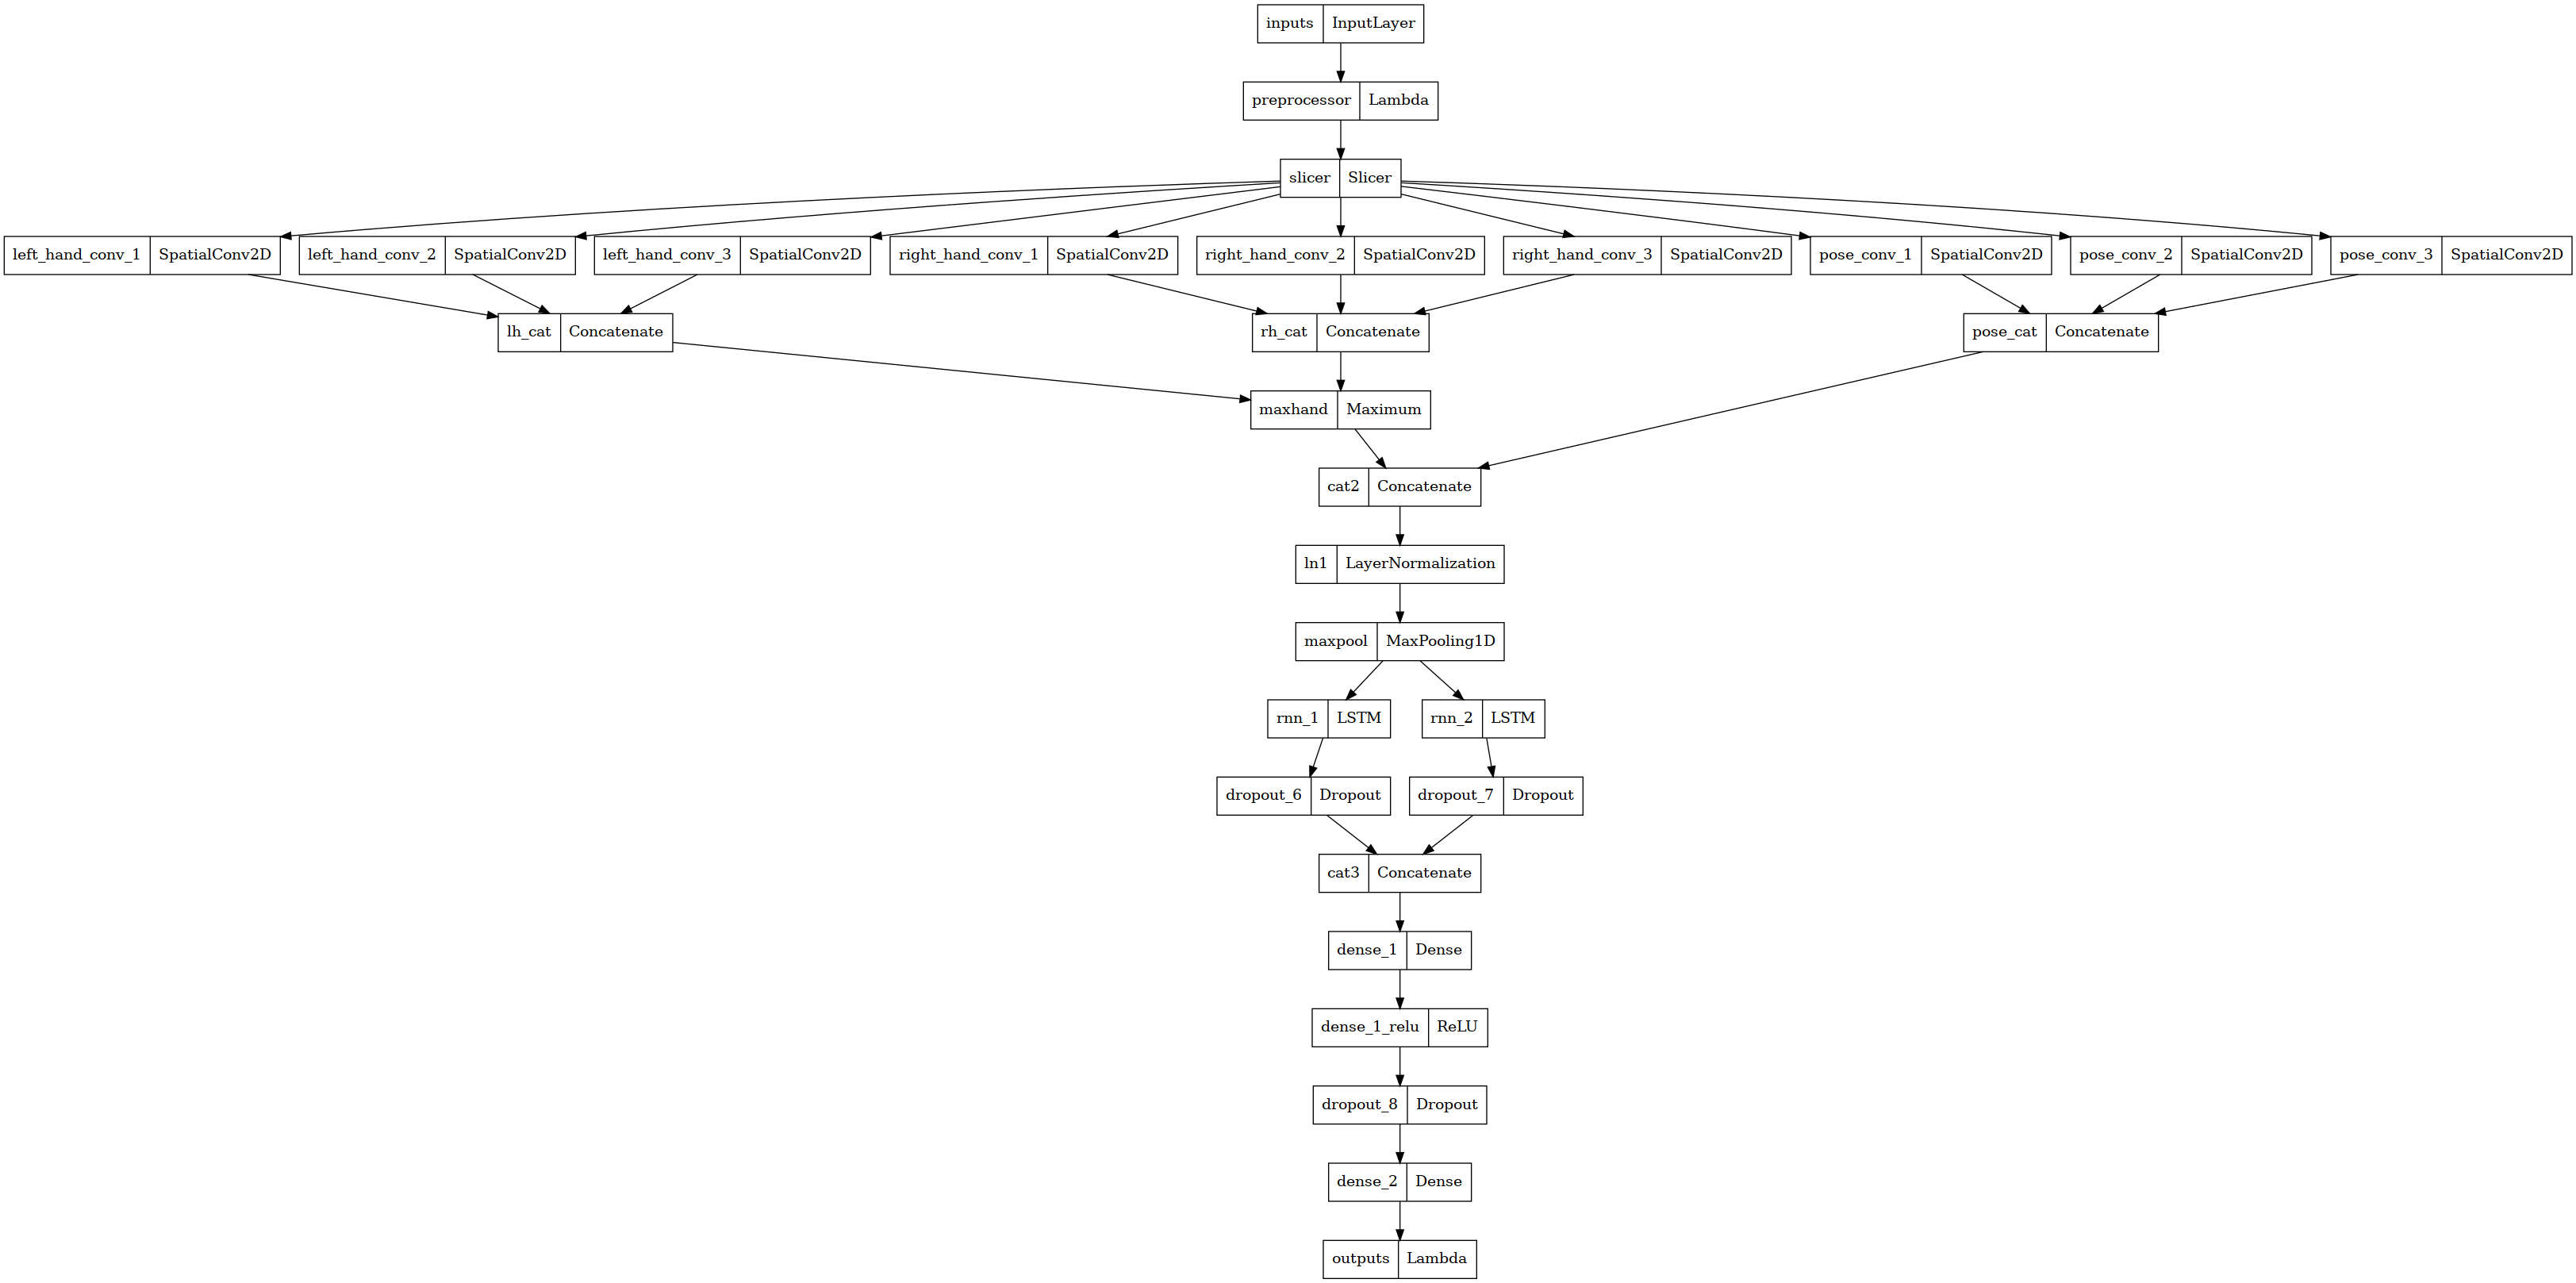

In [37]:
plot_model(prod_model, show_layer_names=True, to_file='model.png')
Image('model.png')

In [38]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        # result = tf.strings.reduce_join(rev_character_map(result)).numpy().decode("utf-8")
        result = "".join([rev_character_map.get(s, "") for s in result.numpy()])
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        # i = 0
        for batch in self.dataset:
            # i += 1
            # if i > 10: 
            #     break
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    # tf.strings.reduce_join(rev_character_map(label)).numpy().decode("utf-8")
                    "".join([rev_character_map.get(s, "") for s in label.numpy()])
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [39]:
import matplotlib.pyplot as plt

def train_round(trainfiles, valfiles, epochs=7, start_at=0):


    train_set = create_dataset(trainfiles)
    valid_set = create_dataset(valfiles)
    
    # Define the number of epochs.
    epochs = epochs
    # Callback function to check transcription on the val set.
    validation_callback = CallbackEval(valid_set)
    # Train the model
    history = model.fit(
        train_set,
        validation_data=valid_set,
        epochs=epochs,
        initial_epoch=start_at,
        callbacks=[validation_callback],
    )

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training loss', 'val_loss'])
    
    del train_set
    del valid_set


    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    gc.collect()

    return



In [40]:
train_round(trainfiles, valfiles, 42)

Epoch 1/42


InvalidArgumentError: in user code:

    File "/tmp/ipykernel_3701350/250210376.py", line 18, in CTCLoss_hard  *
        loss = my_ctc_batch_cost(y_true, y_pred, input_length, label_length)
    File "/tmp/ipykernel_3701350/4187055350.py", line 21, in error_handler  *
        return fn(*args, **kwargs)
    File "/tmp/ipykernel_3701350/4187055350.py", line 40, in my_ctc_batch_cost
        loss = rnnt_loss(logits=y_pred,
    File "/home/ran/AI/asl_spell/./rnnt/source/rnnt_loss.py", line 204, in rnnt_loss
        return compute_rnnt_loss_and_grad(*args)
    File "/home/ran/AI/asl_spell/./rnnt/source/rnnt_loss.py", line 195, in compute_rnnt_loss_and_grad
        result = compute_rnnt_loss_and_grad_helper(**kwargs)
    File "/home/ran/AI/asl_spell/./rnnt/source/rnnt_loss.py", line 112, in compute_rnnt_loss_and_grad_helper
        blank_probs, truth_probs = transition_probs(one_hot_labels, log_probs)
    File "/home/ran/AI/asl_spell/./rnnt/source/rnnt_loss.py", line 35, in transition_probs
        blank_probs = log_probs[:, :, :, 0]

    InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Index out of range using input dim 3; input has only 3 dims [Op:StridedSlice] name: CTCLoss_hard/rnnt_loss/strided_slice/


In [ ]:
train_round(trainfiles, valfiles, 42)

Epoch 1/42
1/1 [==============================] - 0s 337ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6337
----------------------------------------------------------------------------------------------------
Target    : zmfest/duenger/red-ring.html/<pad>
Prediction: zmfest/duenge/red-ring.html/
----------------------------------------------------------------------------------------------------
Target    : 60381 fill road<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Prediction: 60381 fill road
----------------------------------------------------------------------------------------------------
1932/1932 [==============================] - 191s 98ms/step - loss: 4.2907 - val_loss: 3.9090
Epoch 2/42
1/1 [==============================] - 0s 90ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6350
------------

Epoch 1/42
1/1 [==============================] - 0s 221ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.5564
----------------------------------------------------------------------------------------------------
Target    : darcie acosta<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Prediction: darcie acosta
----------------------------------------------------------------------------------------------------
Target    : 855-872-4060<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Prediction: 855-872-4060
----------------------------------------------------------------------------------------------------
1932/1932 [==============================] - 199s 102ms/step - loss: 1.5350 - val_loss: 1.2166
Epoch 2/42
1/1 [==============================] - 0s 96ms/step
-------------------------------------------------------------------------

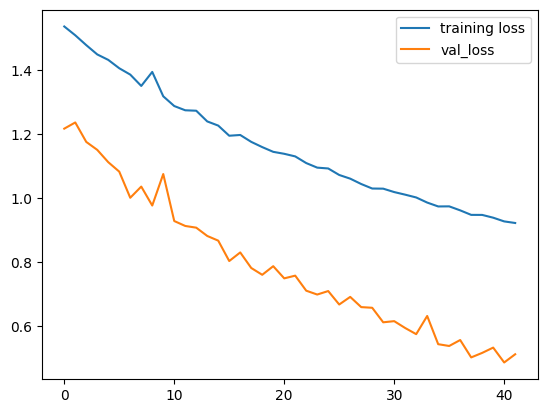

In [54]:
train_round(trainfiles, valfiles, 42)

In [35]:
# train_round(mixed_train_files, mixed_val_files, 126, start_at=84)

In [36]:
# train_round(trainfiles, valfiles, 168, start_at=126)

In [55]:
export_loc = '/home/ran/AI/asl_spell/saved_models/ctc_asl_v2'
# prod_model.save(export_loc)

# Or don't

In [56]:
converter = tf.lite.TFLiteConverter.from_keras_model(prod_model)
# converter = tf.lite.TFLiteConverter.from_saved_model(export_loc)

In [57]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
                                       tf.lite.OpsSet.SELECT_TF_OPS]

In [58]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpsekbtp4t/assets


INFO:tensorflow:Assets written to: /tmp/tmpsekbtp4t/assets


In [59]:
with open(f'{export_loc}/asl_ctc_v2.tflite', 'wb') as f:
    f.write(tflite_model)
    print(f)

<_io.BufferedWriter name='/home/ran/AI/asl_spell/saved_models/ctc_asl_v2/asl_ctc_v2.tflite'>


In [60]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['inputs'], 'outputs': ['outputs']}}


In [61]:
infargs = {"selected_columns" : selected_cols}

with open('inference_args.json', "w") as json_file:
    json.dump(infargs, json_file)

In [22]:
# def load_relevant_data_subset(pq_path):
#     return pd.read_parquet(pq_path, columns=selected_cols)

In [23]:
# def parse_fn_debug(serialized):
#     # Define the features we want to extract
    
#     # Parse the serialized record using the feature dictionary
#     parsed = tf.io.parse_sequence_example(serialized, 
#                                           context_features={'phrase': tf.io.VarLenFeature(tf.int64)},
#                                           sequence_features={col: tf.io.VarLenFeature(tf.float32) for col in selected_cols})
    
#     sequence = ([tf.sparse.to_dense(parsed[1][f]) for f in selected_cols])
#     # print(parsed[1].keys())
#     sequence = tf.transpose(tf.squeeze(sequence))
    
#     phrase = tf.sparse.to_dense(parsed[0]['phrase'])
#     phrase = tf.cast(phrase, tf.int32)
    
#     return sequence, phrase

In [24]:
# sample_file = '/home/ran/AI/asl_spell/data/train_landmarks/152029243.parquet'
# sample_file1 = '/home/ran/AI/asl_spell/data/train_tfr/152029243.tfrecord'

# meta_df = pd.read_csv(data_path + '/train.csv')

# frames = load_relevant_data_subset(sample_file)
# seq_id = meta_df[meta_df.file_id == 152029243].sample(1).sequence_id.iloc[0]
# print(seq_id)

# meta_row = meta_df[meta_df.sequence_id == seq_id]

# frames = frames.loc[seq_id].to_numpy()
# # frames = np.expand_dims(frames, 0)
# true = meta_row['phrase']

# #frames = frames[:0, :]

# x = frames
# print(f"Initial shape is {x.shape}")

# ##################################
# #
# #  Try to deal with empty input
# # 
# ##################################

# # x = x[None]
# # print(f"After first operation {x.shape}")

# # x = tf.cond(tf.shape(x)[1] == 0, 
# #     lambda: tf.ones((1, 2, len(selected_cols))), 
# #     lambda: tf.identity(x))

# # print(f"After second operation {x.shape}")

# # x = x[0]

# # print(f"After third operation {x.shape}")

# # x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

# # x = x[None]

# # print(f"After final operation {x.shape}")

# # frames = x
# # frames = frames[None]
# # frames = frames[:, :]
# print(f"Final shape {frames.shape}")
# # print(tf.rank(frames)[1])

In [25]:
# model_path = '/home/ran/AI/asl_spell/saved_models/ctc_asl_v2/asl_ctc_v2.tflite'

In [26]:
# # import tflite_runtime.interpreter as tflite
# interpreter = tf.lite.Interpreter(model_path)

# REQUIRED_SIGNATURE = "serving_default"
# REQUIRED_OUTPUT = "outputs"

# with open (f'{data_path}/character_to_prediction_index.json', "r") as f:
#     character_map = json.load(f)
# rev_character_map = {j:i for i,j in character_map.items()}

# found_signatures = list(interpreter.get_signature_list().keys())

# if REQUIRED_SIGNATURE not in found_signatures:
#     raise KernelEvalException('Required input signature not found.')

# prediction_fn = interpreter.get_signature_runner("serving_default")
# output = prediction_fn(inputs=frames)

# print(output['outputs'].shape)

# print(np.argmax(output[REQUIRED_OUTPUT], axis=1))

# prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
# # prediction_str = "".join([rev_character_map.get(s, "") for s in output['outputs'][0]])
# print(prediction_str)
# print(true)

# # o = output['outputs'].squeeze()

# #print(np.argmax(output[REQUIRED_OUTPUT], axis=1))
# # o = tf.one_hot(o, 59, axis=1)
# # print("".join([rev_character_map.get(s, "") for s in np.argmax(o, axis=1)]))